In [165]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [166]:
import copy, math

In [167]:
import plotly.express as px

In [168]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [169]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import plotly.graph_objects as go
init_notebook_mode(connected=True)

In [170]:
def format_comma(num):
    return f'{num:,.0f}'

# Setup

## Define all keys

In [171]:
state_key = {
'EC':'Eastern Cape',
'FS':'Free State',
'GP':'Gauteng',
'KZN':'Kwazulu Natal',
'LP':'Limpopo',
'MP':'Mpumalanga',
'NC':'Northern Cape',
'NW':'North-West',
'WC':'Western Cape'
}
state_filter = list(state_key.keys())
state_filter

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [172]:
state_labels = list(state_key.values())
state_labels

['Eastern Cape',
 'Free State',
 'Gauteng',
 'Kwazulu Natal',
 'Limpopo',
 'Mpumalanga',
 'Northern Cape',
 'North-West',
 'Western Cape']

In [173]:
#not required
state_filter_d = copy.deepcopy(state_filter)
state_filter_d.append('Date')
state_filter_d

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

In [174]:
state_filter_t = copy.deepcopy(state_filter)
state_filter_t.insert(0,'Total RSA')
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [175]:
state_filter_all = copy.deepcopy(state_filter)
state_filter_all.insert(0,'Total RSA')
state_filter_all.append('Date')
state_filter_all

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

## Download SA population stats

In [176]:
# Mid-year 2019 Estimates
# https://www.statssa.gov.za/publications/P0302/P03022019.pdf
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
province_pops = pd.read_csv(url, header=None, names=['Province','Pop'])
province_pops

Province       Pop
0        Gauteng  15176115
1  KwaZulu-Natal  11289086
2   Western Cape   6844272
3   Eastern Cape   6712276
4        Limpopo   5982584
5     Mpumalanga   4592187
6      Northwest   4027160
7     Free State   2887465
8  Northern Cape   1263875

In [177]:
country_pop = province_pops['Pop'].sum()
country_pop

58775020

In [178]:
province_pops.iloc[0]['Pop']

15176115

In [179]:
state_pop = {
    'EC': 6712276,
    'FS': 2887465,
    'GP': 15176115,
    'KZN': 11289086,
    'LP': 5982584,
    'MP': 4592187,
    'NC': 1263875,
    'NW': 4027160,
    'WC': 6844272
}

# SQL Import Test

In [180]:
import sqlite3

con = sqlite3.connect("../db.sqlite3")

df = pd.read_sql_query('SELECT * FROM dashboard_coviddata', con)
df

id        date var   EC   FS   GP  KZN   LP   MP   NC   NW  unknown  \
0    1295  2020-03-05   C  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0   
1    1296  2020-03-07   C  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0      0.0   
2    1297  2020-03-08   C  0.0  0.0  1.0  2.0  0.0  0.0  0.0  0.0      0.0   
3    1298  2020-03-09   C  0.0  0.0  1.0  6.0  0.0  0.0  0.0  0.0      0.0   
4    1299  2020-03-11   C  0.0  0.0  5.0  7.0  0.0  0.0  0.0  0.0      0.0   
..    ...         ...  ..  ...  ...  ...  ...  ...  ...  ...  ...      ...   
991  2287  2020-11-22   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   
992  2288  2020-11-23   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   
993  2289  2020-11-24   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   
994  2290  2020-11-25   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   
995  2291  2020-11-26   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   

       total source   WC  
0          1         0.0  
1          2         0.0  
2          3         0.0  
3          7         0.0  
4         13         1.0  
..       ...    ...  ...  
991  5290966         NaN  
992  5305343         NaN  
993  5325631         NaN  
994  5355068         NaN  
995  5383078         NaN  

[996 rows x 15 columns]

# Download Data

## Download case data

In [181]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=0)
states_cases_i

YYYYMMDD        EC       FS        GP       KZN       LP       MP  \
date                                                                            
2020-03-05  20200305       0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307       0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308       0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309       0.0      0.0       1.0       6.0      0.0      0.0   
2020-03-11  20200311       0.0      0.0       5.0       7.0      0.0      0.0   
...              ...       ...      ...       ...       ...      ...      ...   
2020-11-22  20201122  117374.0  58766.0  233036.0  126034.0  18399.0  31072.0   
2020-11-23  20201123  118688.0  58796.0  233164.0  126130.0  18408.0  31086.0   
2020-11-24  20201124  120052.0  58812.0  233343.0  126290.0  18420.0  31121.0   
2020-11-25  20201125  121329.0  58846.0  233710.0  126635.0  18439.0  31163.0   
2020-11-26  20201126  122587.0  58912.0  233995.0  126866.0  18477.0  31215.0   

                 NC       NW        WC  UNKNOWN   total  \
date                                                      
2020-03-05      0.0      0.0       0.0      0.0       1   
2020-03-07      0.0      0.0       0.0      0.0       2   
2020-03-08      0.0      0.0       0.0      0.0       3   
2020-03-09      0.0      0.0       0.0      0.0       7   
2020-03-11      0.0      0.0       1.0      0.0      13   
...             ...      ...       ...      ...     ...   
2020-11-22  22952.0  34597.0  125449.0      0.0  767679   
2020-11-23  22968.0  34600.0  125919.0      0.0  769759   
2020-11-24  23003.0  34640.0  126571.0      0.0  772252   
2020-11-25  23044.0  34690.0  127646.0      0.0  775502   
2020-11-26  23095.0  34721.0  128703.0      0.0  778571   

                                                       source  
date                                                           
2020-03-05                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
2020-03-11                                                NaN  
...                                                       ...  
2020-11-22  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-23  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  

[265 rows x 13 columns]

In [182]:
casezero = states_cases_i.index[0]
caselast = states_cases_i.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-11-26 00:00:00'))

In [183]:
idx = pd.date_range(casezero, caselast)
idx

DatetimeIndex(['2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14',
               ...
               '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20',
               '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24',
               '2020-11-25', '2020-11-26'],
              dtype='datetime64[ns]', length=267, freq='D')

In [184]:
states_cases_i = states_cases_i.reindex(idx, method='ffill')
states_cases_i = states_cases_i.rename(columns={'total':'Total RSA'})
states_cases_i

YYYYMMDD        EC       FS        GP       KZN       LP       MP  \
2020-03-05  20200305       0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-06  20200305       0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307       0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308       0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309       0.0      0.0       1.0       6.0      0.0      0.0   
...              ...       ...      ...       ...       ...      ...      ...   
2020-11-22  20201122  117374.0  58766.0  233036.0  126034.0  18399.0  31072.0   
2020-11-23  20201123  118688.0  58796.0  233164.0  126130.0  18408.0  31086.0   
2020-11-24  20201124  120052.0  58812.0  233343.0  126290.0  18420.0  31121.0   
2020-11-25  20201125  121329.0  58846.0  233710.0  126635.0  18439.0  31163.0   
2020-11-26  20201126  122587.0  58912.0  233995.0  126866.0  18477.0  31215.0   

                 NC       NW        WC  UNKNOWN  Total RSA  \
2020-03-05      0.0      0.0       0.0      0.0          1   
2020-03-06      0.0      0.0       0.0      0.0          1   
2020-03-07      0.0      0.0       0.0      0.0          2   
2020-03-08      0.0      0.0       0.0      0.0          3   
2020-03-09      0.0      0.0       0.0      0.0          7   
...             ...      ...       ...      ...        ...   
2020-11-22  22952.0  34597.0  125449.0      0.0     767679   
2020-11-23  22968.0  34600.0  125919.0      0.0     769759   
2020-11-24  23003.0  34640.0  126571.0      0.0     772252   
2020-11-25  23044.0  34690.0  127646.0      0.0     775502   
2020-11-26  23095.0  34721.0  128703.0      0.0     778571   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-11-22  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-23  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  

[267 rows x 13 columns]

In [228]:
# Validate totals
states_cases_i = states_cases_i[state_filter]
states_cases_i['Total RSA'] = states_cases_i.sum(axis=1)
states_cases_i

EC       FS        GP       KZN       LP       MP       NC  \
2020-03-05       0.0      0.0       0.0       1.0      0.0      0.0      0.0   
2020-03-06       0.0      0.0       0.0       1.0      0.0      0.0      0.0   
2020-03-07       0.0      0.0       1.0       1.0      0.0      0.0      0.0   
2020-03-08       0.0      0.0       1.0       2.0      0.0      0.0      0.0   
2020-03-09       0.0      0.0       1.0       6.0      0.0      0.0      0.0   
...              ...      ...       ...       ...      ...      ...      ...   
2020-11-22  117374.0  58766.0  233036.0  126034.0  18399.0  31072.0  22952.0   
2020-11-23  118688.0  58796.0  233164.0  126130.0  18408.0  31086.0  22968.0   
2020-11-24  120052.0  58812.0  233343.0  126290.0  18420.0  31121.0  23003.0   
2020-11-25  121329.0  58846.0  233710.0  126635.0  18439.0  31163.0  23044.0   
2020-11-26  122587.0  58912.0  233995.0  126866.0  18477.0  31215.0  23095.0   

                 NW        WC  Total RSA  
2020-03-05      0.0       0.0        1.0  
2020-03-06      0.0       0.0        1.0  
2020-03-07      0.0       0.0        2.0  
2020-03-08      0.0       0.0        3.0  
2020-03-09      0.0       0.0        7.0  
...             ...       ...        ...  
2020-11-22  34597.0  125449.0   767679.0  
2020-11-23  34600.0  125919.0   769759.0  
2020-11-24  34640.0  126571.0   772252.0  
2020-11-25  34690.0  127646.0   775502.0  
2020-11-26  34721.0  128703.0   778571.0  

[267 rows x 10 columns]

In [229]:
states_cases = states_cases_i.copy()
states_cases = states_cases.reset_index()
states_cases = states_cases.rename(columns={'index':'Date'})
states_cases

Date        EC       FS        GP       KZN       LP       MP  \
0   2020-03-05       0.0      0.0       0.0       1.0      0.0      0.0   
1   2020-03-06       0.0      0.0       0.0       1.0      0.0      0.0   
2   2020-03-07       0.0      0.0       1.0       1.0      0.0      0.0   
3   2020-03-08       0.0      0.0       1.0       2.0      0.0      0.0   
4   2020-03-09       0.0      0.0       1.0       6.0      0.0      0.0   
..         ...       ...      ...       ...       ...      ...      ...   
262 2020-11-22  117374.0  58766.0  233036.0  126034.0  18399.0  31072.0   
263 2020-11-23  118688.0  58796.0  233164.0  126130.0  18408.0  31086.0   
264 2020-11-24  120052.0  58812.0  233343.0  126290.0  18420.0  31121.0   
265 2020-11-25  121329.0  58846.0  233710.0  126635.0  18439.0  31163.0   
266 2020-11-26  122587.0  58912.0  233995.0  126866.0  18477.0  31215.0   

          NC       NW        WC  Total RSA  
0        0.0      0.0       0.0        1.0  
1        0.0      0.0       0.0        1.0  
2        0.0      0.0       0.0        2.0  
3        0.0      0.0       0.0        3.0  
4        0.0      0.0       0.0        7.0  
..       ...      ...       ...        ...  
262  22952.0  34597.0  125449.0   767679.0  
263  22968.0  34600.0  125919.0   769759.0  
264  23003.0  34640.0  126571.0   772252.0  
265  23044.0  34690.0  127646.0   775502.0  
266  23095.0  34721.0  128703.0   778571.0  

[267 rows x 11 columns]

## Download death data

In [230]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv'
states_deaths_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_deaths_i

YYYYMMDD    EC    FS    GP   KZN   LP   MP   NC   NW    WC  \
date                                                                     
2020-03-27  20200327     0     0     0     0    0    0    0    0     1   
2020-03-28  20200328     0     0     0     1    0    0    0    0     1   
2020-03-30  20200330     0     1     0     1    0    0    0    0     1   
2020-03-31  20200331     0     1     1     2    0    0    0    0     1   
2020-04-03  20200403     0     1     1     6    0    0    0    0     1   
...              ...   ...   ...   ...   ...  ...  ...  ...  ...   ...   
2020-11-22  20201122  4353  1807  4968  3309  487  614  301  541  4523   
2020-11-23  20201123  4379  1826  4970  3309  490  614  301  549  4530   
2020-11-24  20201124  4424  1846  4989  3319  490  614  306  549  4546   
2020-11-25  20201125  4475  1870  4996  3321  494  614  306  549  4576   
2020-11-26  20201126  4508  1895  5001  3323  499  614  306  549  4594   

            UNKNOWN  total                                             source  
date                                                                           
2020-03-27        0      1  https://sacoronavirus.co.za/2020/03/27/latest-...  
2020-03-28        0      2                                                NaN  
2020-03-30        0      3                                                NaN  
2020-03-31        0      5                                                NaN  
2020-04-03        0      9                                                NaN  
...             ...    ...                                                ...  
2020-11-22        0  20903  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-23        0  20968  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-24        0  21083  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25        0  21201  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26        0  21289  https://www.nicd.ac.za/latest-confirmed-cases-...  

[241 rows x 13 columns]

In [231]:
states_deaths_i = states_deaths_i.reindex(idx, method='ffill')
states_deaths_i

YYYYMMDD      EC      FS      GP     KZN     LP     MP     NC  \
2020-03-05         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-06         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-07         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-08         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-09         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
...                ...     ...     ...     ...     ...    ...    ...    ...   
2020-11-22  20201122.0  4353.0  1807.0  4968.0  3309.0  487.0  614.0  301.0   
2020-11-23  20201123.0  4379.0  1826.0  4970.0  3309.0  490.0  614.0  301.0   
2020-11-24  20201124.0  4424.0  1846.0  4989.0  3319.0  490.0  614.0  306.0   
2020-11-25  20201125.0  4475.0  1870.0  4996.0  3321.0  494.0  614.0  306.0   
2020-11-26  20201126.0  4508.0  1895.0  5001.0  3323.0  499.0  614.0  306.0   

               NW      WC  UNKNOWN    total  \
2020-03-05    NaN     NaN      NaN      NaN   
2020-03-06    NaN     NaN      NaN      NaN   
2020-03-07    NaN     NaN      NaN      NaN   
2020-03-08    NaN     NaN      NaN      NaN   
2020-03-09    NaN     NaN      NaN      NaN   
...           ...     ...      ...      ...   
2020-11-22  541.0  4523.0      0.0  20903.0   
2020-11-23  549.0  4530.0      0.0  20968.0   
2020-11-24  549.0  4546.0      0.0  21083.0   
2020-11-25  549.0  4576.0      0.0  21201.0   
2020-11-26  549.0  4594.0      0.0  21289.0   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-11-22  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-23  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  

[267 rows x 13 columns]

In [232]:
states_deaths_i.iloc[0, :] = states_deaths_i.iloc[0, :].replace({np.nan:0})
states_deaths_i = states_deaths_i.ffill(axis=0)
states_deaths_i = states_deaths_i.rename(columns={'total':'Total RSA'})
states_deaths_i

YYYYMMDD      EC      FS      GP     KZN     LP     MP     NC  \
2020-03-05         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-06         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-07         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-08         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-09         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
...                ...     ...     ...     ...     ...    ...    ...    ...   
2020-11-22  20201122.0  4353.0  1807.0  4968.0  3309.0  487.0  614.0  301.0   
2020-11-23  20201123.0  4379.0  1826.0  4970.0  3309.0  490.0  614.0  301.0   
2020-11-24  20201124.0  4424.0  1846.0  4989.0  3319.0  490.0  614.0  306.0   
2020-11-25  20201125.0  4475.0  1870.0  4996.0  3321.0  494.0  614.0  306.0   
2020-11-26  20201126.0  4508.0  1895.0  5001.0  3323.0  499.0  614.0  306.0   

               NW      WC  UNKNOWN  Total RSA  \
2020-03-05    0.0     0.0      0.0        0.0   
2020-03-06    0.0     0.0      0.0        0.0   
2020-03-07    0.0     0.0      0.0        0.0   
2020-03-08    0.0     0.0      0.0        0.0   
2020-03-09    0.0     0.0      0.0        0.0   
...           ...     ...      ...        ...   
2020-11-22  541.0  4523.0      0.0    20903.0   
2020-11-23  549.0  4530.0      0.0    20968.0   
2020-11-24  549.0  4546.0      0.0    21083.0   
2020-11-25  549.0  4576.0      0.0    21201.0   
2020-11-26  549.0  4594.0      0.0    21289.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-11-22  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-23  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  

[267 rows x 13 columns]

In [233]:
states_deaths = states_deaths_i.copy()
states_deaths = states_deaths.reset_index()
states_deaths = states_deaths.rename(columns={'index':'Date'})
states_deaths

Date    YYYYMMDD      EC      FS      GP     KZN     LP     MP  \
0   2020-03-05         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
1   2020-03-06         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
2   2020-03-07         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
3   2020-03-08         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
4   2020-03-09         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
..         ...         ...     ...     ...     ...     ...    ...    ...   
262 2020-11-22  20201122.0  4353.0  1807.0  4968.0  3309.0  487.0  614.0   
263 2020-11-23  20201123.0  4379.0  1826.0  4970.0  3309.0  490.0  614.0   
264 2020-11-24  20201124.0  4424.0  1846.0  4989.0  3319.0  490.0  614.0   
265 2020-11-25  20201125.0  4475.0  1870.0  4996.0  3321.0  494.0  614.0   
266 2020-11-26  20201126.0  4508.0  1895.0  5001.0  3323.0  499.0  614.0   

        NC     NW      WC  UNKNOWN  Total RSA  \
0      0.0    0.0     0.0      0.0        0.0   
1      0.0    0.0     0.0      0.0        0.0   
2      0.0    0.0     0.0      0.0        0.0   
3      0.0    0.0     0.0      0.0        0.0   
4      0.0    0.0     0.0      0.0        0.0   
..     ...    ...     ...      ...        ...   
262  301.0  541.0  4523.0      0.0    20903.0   
263  301.0  549.0  4530.0      0.0    20968.0   
264  306.0  549.0  4546.0      0.0    21083.0   
265  306.0  549.0  4576.0      0.0    21201.0   
266  306.0  549.0  4594.0      0.0    21289.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
262  https://www.nicd.ac.za/latest-confirmed-cases-...  
263  https://www.nicd.ac.za/latest-confirmed-cases-...  
264  https://www.nicd.ac.za/latest-confirmed-cases-...  
265  https://www.nicd.ac.za/latest-confirmed-cases-...  
266  https://www.nicd.ac.za/latest-confirmed-cases-...  

[267 rows x 14 columns]

## Download recovery data

In [234]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv'
states_recovery_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_recovery_i

YYYYMMDD      EC     FS        GP     KZN     LP     MP     NC  \
date                                                                         
2020-04-17  20200417       9     71     479.0      96     18      9     10   
2020-04-18  20200418       9     71     479.0      96     18      9     10   
2020-04-19  20200419       9     71     479.0      96     18      9     10   
2020-04-20  20200420      15     74     545.0     151     21     14     13   
2020-04-21  20200421      15     74     545.0     151     21     14     13   
...              ...     ...    ...       ...     ...    ...    ...    ...   
2020-11-22  20201122  103210  49231  227707.0  116591  17579  30026  19290   
2020-11-23  20201123  103210  49311  227911.0  117238  17620  30088  19298   
2020-11-24  20201124  107116  49686  228111.0  117326  17637  30134  19428   
2020-11-25  20201125  107116  50174       NaN  117329  17637  30150  19449   
2020-11-26  20201126  109170  50532       NaN  117376  17662  30166  20061   

               NW      WC  UNKNOWN     total  \
date                                           
2020-04-17      6     205        0     903.0   
2020-04-18      6     205        0     903.0   
2020-04-19      6     205        0     903.0   
2020-04-20      6     216        0    1055.0   
2020-04-21      6     216        0    1055.0   
...           ...     ...      ...       ...   
2020-11-22  32861  113604        0  710099.0   
2020-11-23  32861  113658        0  711195.0   
2020-11-24  32861  114145        0  716444.0   
2020-11-25  33115  114548        0       NaN   
2020-11-26  33115  115017        0       NaN   

                                                       source  
date                                                           
2020-04-17  https://twitter.com/nicd_sa/status/12512151947...  
2020-04-18  https://twitter.com/nicd_sa/status/12515952235...  
2020-04-19  https://twitter.com/nicd_sa/status/12519270552...  
2020-04-20  https://twitter.com/nicd_sa/status/12523098244...  
2020-04-21  https://twitter.com/nicd_sa/status/12526435556...  
...                                                       ...  
2020-11-22  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-23  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  

[218 rows x 13 columns]

In [235]:
states_recovery_i = states_recovery_i.reindex(idx, method='ffill')
states_recovery_i

YYYYMMDD        EC       FS        GP       KZN       LP  \
2020-03-05         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-06         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-07         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-08         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-09         NaN       NaN      NaN       NaN       NaN      NaN   
...                ...       ...      ...       ...       ...      ...   
2020-11-22  20201122.0  103210.0  49231.0  227707.0  116591.0  17579.0   
2020-11-23  20201123.0  103210.0  49311.0  227911.0  117238.0  17620.0   
2020-11-24  20201124.0  107116.0  49686.0  228111.0  117326.0  17637.0   
2020-11-25  20201125.0  107116.0  50174.0       NaN  117329.0  17637.0   
2020-11-26  20201126.0  109170.0  50532.0       NaN  117376.0  17662.0   

                 MP       NC       NW        WC  UNKNOWN     total  \
2020-03-05      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-06      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-07      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-08      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-09      NaN      NaN      NaN       NaN      NaN       NaN   
...             ...      ...      ...       ...      ...       ...   
2020-11-22  30026.0  19290.0  32861.0  113604.0      0.0  710099.0   
2020-11-23  30088.0  19298.0  32861.0  113658.0      0.0  711195.0   
2020-11-24  30134.0  19428.0  32861.0  114145.0      0.0  716444.0   
2020-11-25  30150.0  19449.0  33115.0  114548.0      0.0       NaN   
2020-11-26  30166.0  20061.0  33115.0  115017.0      0.0       NaN   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-11-22  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-23  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  

[267 rows x 13 columns]

In [236]:
states_recovery_i.iloc[0, :] = states_recovery_i.iloc[0, :].replace({np.nan:0})
states_recovery_i = states_recovery_i.ffill(axis=0)
states_recovery_i = states_recovery_i.rename(columns={'total':'Total RSA'})
states_recovery_i

YYYYMMDD        EC       FS        GP       KZN       LP  \
2020-03-05         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-06         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-07         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-08         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-09         0.0       0.0      0.0       0.0       0.0      0.0   
...                ...       ...      ...       ...       ...      ...   
2020-11-22  20201122.0  103210.0  49231.0  227707.0  116591.0  17579.0   
2020-11-23  20201123.0  103210.0  49311.0  227911.0  117238.0  17620.0   
2020-11-24  20201124.0  107116.0  49686.0  228111.0  117326.0  17637.0   
2020-11-25  20201125.0  107116.0  50174.0  228111.0  117329.0  17637.0   
2020-11-26  20201126.0  109170.0  50532.0  228111.0  117376.0  17662.0   

                 MP       NC       NW        WC  UNKNOWN  Total RSA  \
2020-03-05      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-06      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-07      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-08      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-09      0.0      0.0      0.0       0.0      0.0        0.0   
...             ...      ...      ...       ...      ...        ...   
2020-11-22  30026.0  19290.0  32861.0  113604.0      0.0   710099.0   
2020-11-23  30088.0  19298.0  32861.0  113658.0      0.0   711195.0   
2020-11-24  30134.0  19428.0  32861.0  114145.0      0.0   716444.0   
2020-11-25  30150.0  19449.0  33115.0  114548.0      0.0   716444.0   
2020-11-26  30166.0  20061.0  33115.0  115017.0      0.0   716444.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-11-22  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-23  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  

[267 rows x 13 columns]

In [237]:
states_recovery = states_recovery_i.copy()
states_recovery = states_recovery.reset_index()
states_recovery = states_recovery.rename(columns={'index':'Date'})
states_recovery

Date    YYYYMMDD        EC       FS        GP       KZN       LP  \
0   2020-03-05         0.0       0.0      0.0       0.0       0.0      0.0   
1   2020-03-06         0.0       0.0      0.0       0.0       0.0      0.0   
2   2020-03-07         0.0       0.0      0.0       0.0       0.0      0.0   
3   2020-03-08         0.0       0.0      0.0       0.0       0.0      0.0   
4   2020-03-09         0.0       0.0      0.0       0.0       0.0      0.0   
..         ...         ...       ...      ...       ...       ...      ...   
262 2020-11-22  20201122.0  103210.0  49231.0  227707.0  116591.0  17579.0   
263 2020-11-23  20201123.0  103210.0  49311.0  227911.0  117238.0  17620.0   
264 2020-11-24  20201124.0  107116.0  49686.0  228111.0  117326.0  17637.0   
265 2020-11-25  20201125.0  107116.0  50174.0  228111.0  117329.0  17637.0   
266 2020-11-26  20201126.0  109170.0  50532.0  228111.0  117376.0  17662.0   

          MP       NC       NW        WC  UNKNOWN  Total RSA  \
0        0.0      0.0      0.0       0.0      0.0        0.0   
1        0.0      0.0      0.0       0.0      0.0        0.0   
2        0.0      0.0      0.0       0.0      0.0        0.0   
3        0.0      0.0      0.0       0.0      0.0        0.0   
4        0.0      0.0      0.0       0.0      0.0        0.0   
..       ...      ...      ...       ...      ...        ...   
262  30026.0  19290.0  32861.0  113604.0      0.0   710099.0   
263  30088.0  19298.0  32861.0  113658.0      0.0   711195.0   
264  30134.0  19428.0  32861.0  114145.0      0.0   716444.0   
265  30150.0  19449.0  33115.0  114548.0      0.0   716444.0   
266  30166.0  20061.0  33115.0  115017.0      0.0   716444.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
262  https://www.nicd.ac.za/latest-confirmed-cases-...  
263  https://www.nicd.ac.za/latest-confirmed-cases-...  
264  https://www.nicd.ac.za/latest-confirmed-cases-...  
265  https://www.nicd.ac.za/latest-confirmed-cases-...  
266  https://www.nicd.ac.za/latest-confirmed-cases-...  

[267 rows x 14 columns]

## Download testing data
Only for country

In [238]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests_i = states_tests_i['cumulative_tests']
states_tests_i

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-11-22    5290966.0
2020-11-23    5305343.0
2020-11-24    5325631.0
2020-11-25    5355068.0
2020-11-26    5383078.0
Name: cumulative_tests, Length: 272, dtype: float64

In [239]:
states_tests_i = states_tests_i.reindex(idx, method='ffill')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-11-22    5290966.0
2020-11-23    5305343.0
2020-11-24    5325631.0
2020-11-25    5355068.0
2020-11-26    5383078.0
Freq: D, Name: cumulative_tests, Length: 267, dtype: float64

In [240]:
states_tests_i = states_tests_i.ffill(axis=0)
states_tests_i = states_tests_i.rename('Total RSA')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-11-22    5290966.0
2020-11-23    5305343.0
2020-11-24    5325631.0
2020-11-25    5355068.0
2020-11-26    5383078.0
Freq: D, Name: Total RSA, Length: 267, dtype: float64

In [241]:
states_tests = states_tests_i.copy()
states_tests = states_tests.reset_index()
states_tests = states_tests.rename(columns={'index':'Date'})
states_tests

Date  Total RSA
0   2020-03-05      164.0
1   2020-03-06      200.0
2   2020-03-07      241.0
3   2020-03-08      241.0
4   2020-03-09      241.0
..         ...        ...
262 2020-11-22  5290966.0
263 2020-11-23  5305343.0
264 2020-11-24  5325631.0
265 2020-11-25  5355068.0
266 2020-11-26  5383078.0

[267 rows x 2 columns]

# Analysis Per Province

In [242]:
#https://plotly.com/python/discrete-color/#color-sequences-in-plotly-express
colour_series = px.colors.qualitative.Vivid

In [243]:
filter_cases = states_cases[state_filter_all]
analysis_cases = filter_cases.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_cases['Data'] = 'Cases'

filter_recovery = states_recovery[state_filter_all]
analysis_recovery = filter_recovery.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_recovery['Data'] = 'Recovered'

filter_deaths = states_deaths[state_filter_all]
analysis_deaths = filter_deaths.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_deaths['Data'] = 'Deaths'

In [244]:
filter_add = pd.concat([filter_deaths, filter_recovery])
filter_add = filter_add.groupby('Date').sum()
filter_add

Total RSA        EC       FS        GP       KZN       LP  \
Date                                                                    
2020-03-05        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-06        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-07        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-08        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-09        0.0       0.0      0.0       0.0       0.0      0.0   
...               ...       ...      ...       ...       ...      ...   
2020-11-22   731002.0  107563.0  51038.0  232675.0  119900.0  18066.0   
2020-11-23   732163.0  107589.0  51137.0  232881.0  120547.0  18110.0   
2020-11-24   737527.0  111540.0  51532.0  233100.0  120645.0  18127.0   
2020-11-25   737645.0  111591.0  52044.0  233107.0  120650.0  18131.0   
2020-11-26   737733.0  113678.0  52427.0  233112.0  120699.0  18161.0   

                 MP       NC       NW        WC  
Date                                             
2020-03-05      0.0      0.0      0.0       0.0  
2020-03-06      0.0      0.0      0.0       0.0  
2020-03-07      0.0      0.0      0.0       0.0  
2020-03-08      0.0      0.0      0.0       0.0  
2020-03-09      0.0      0.0      0.0       0.0  
...             ...      ...      ...       ...  
2020-11-22  30640.0  19591.0  33402.0  118127.0  
2020-11-23  30702.0  19599.0  33410.0  118188.0  
2020-11-24  30748.0  19734.0  33410.0  118691.0  
2020-11-25  30764.0  19755.0  33664.0  119124.0  
2020-11-26  30780.0  20367.0  33664.0  119611.0  

[267 rows x 10 columns]

In [245]:
filter_sub = filter_add.rmul(-1).reset_index()
filter_sub

Date  Total RSA        EC       FS        GP       KZN       LP  \
0   2020-03-05       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
1   2020-03-06       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
2   2020-03-07       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
3   2020-03-08       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
4   2020-03-09       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
..         ...        ...       ...      ...       ...       ...      ...   
262 2020-11-22  -731002.0 -107563.0 -51038.0 -232675.0 -119900.0 -18066.0   
263 2020-11-23  -732163.0 -107589.0 -51137.0 -232881.0 -120547.0 -18110.0   
264 2020-11-24  -737527.0 -111540.0 -51532.0 -233100.0 -120645.0 -18127.0   
265 2020-11-25  -737645.0 -111591.0 -52044.0 -233107.0 -120650.0 -18131.0   
266 2020-11-26  -737733.0 -113678.0 -52427.0 -233112.0 -120699.0 -18161.0   

          MP       NC       NW        WC  
0       -0.0     -0.0     -0.0      -0.0  
1       -0.0     -0.0     -0.0      -0.0  
2       -0.0     -0.0     -0.0      -0.0  
3       -0.0     -0.0     -0.0      -0.0  
4       -0.0     -0.0     -0.0      -0.0  
..       ...      ...      ...       ...  
262 -30640.0 -19591.0 -33402.0 -118127.0  
263 -30702.0 -19599.0 -33410.0 -118188.0  
264 -30748.0 -19734.0 -33410.0 -118691.0  
265 -30764.0 -19755.0 -33664.0 -119124.0  
266 -30780.0 -20367.0 -33664.0 -119611.0  

[267 rows x 11 columns]

In [246]:
filter_active_i = pd.concat([filter_cases, filter_sub])
filter_active_i = filter_active_i.groupby('Date').sum()
filter_active = filter_active_i.reset_index()
filter_active = filter_active.rename(columns={'index':'Date'})
filter_active

Date  Total RSA       EC      FS     GP     KZN     LP     MP  \
0   2020-03-05        1.0      0.0     0.0    0.0     1.0    0.0    0.0   
1   2020-03-06        1.0      0.0     0.0    0.0     1.0    0.0    0.0   
2   2020-03-07        2.0      0.0     0.0    1.0     1.0    0.0    0.0   
3   2020-03-08        3.0      0.0     0.0    1.0     2.0    0.0    0.0   
4   2020-03-09        7.0      0.0     0.0    1.0     6.0    0.0    0.0   
..         ...        ...      ...     ...    ...     ...    ...    ...   
262 2020-11-22    36677.0   9811.0  7728.0  361.0  6134.0  333.0  432.0   
263 2020-11-23    37596.0  11099.0  7659.0  283.0  5583.0  298.0  384.0   
264 2020-11-24    34725.0   8512.0  7280.0  243.0  5645.0  293.0  373.0   
265 2020-11-25    37857.0   9738.0  6802.0  603.0  5985.0  308.0  399.0   
266 2020-11-26    40838.0   8909.0  6485.0  883.0  6167.0  316.0  435.0   

         NC      NW      WC  
0       0.0     0.0     0.0  
1       0.0     0.0     0.0  
2       0.0     0.0     0.0  
3       0.0     0.0     0.0  
4       0.0     0.0     0.0  
..      ...     ...     ...  
262  3361.0  1195.0  7322.0  
263  3369.0  1190.0  7731.0  
264  3269.0  1230.0  7880.0  
265  3289.0  1026.0  8522.0  
266  2728.0  1057.0  9092.0  

[267 rows x 11 columns]

In [247]:
analysis_active = filter_active.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_active['Data'] = 'Active'

In [248]:
analysis_all = pd.concat([analysis_cases, analysis_recovery, analysis_active, analysis_deaths])
analysis_all

Date   Province   Value    Data
0    2020-03-05  Total RSA     1.0   Cases
1    2020-03-06  Total RSA     1.0   Cases
2    2020-03-07  Total RSA     2.0   Cases
3    2020-03-08  Total RSA     3.0   Cases
4    2020-03-09  Total RSA     7.0   Cases
...         ...        ...     ...     ...
2665 2020-11-22         WC  4523.0  Deaths
2666 2020-11-23         WC  4530.0  Deaths
2667 2020-11-24         WC  4546.0  Deaths
2668 2020-11-25         WC  4576.0  Deaths
2669 2020-11-26         WC  4594.0  Deaths

[10680 rows x 4 columns]

In [249]:
analysis_states = analysis_all.query(f"Province != 'Total RSA'")
analysis_country = analysis_all.query(f"Province == 'Total RSA'")

In [250]:
template_h = '%{y}'

## Plot analysis for provinces

In [251]:
fig_analysis_prov = px.bar(analysis_states, title='Analysis For Provinces',
             x='Date', y='Value', color='Province', animation_frame='Data',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_prov.update_layout(plot_bgcolor="#FFF",hovermode="x", height=650)
fig_analysis_prov.update_xaxes(linecolor="#BCCCDC")
fig_analysis_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_prov.update_traces(hovertemplate=template_h)
fig_analysis_prov["layout"].pop("updatemenus") # remove play controls
fig_analysis_prov.show()
#plot_analsysis_prov = plot(fig_analysis_prov, output_type='div', include_plotlyjs=False, auto_play=False)

## Plot analysis for deaths

In [252]:
analysis_states_deaths = analysis_deaths.query(f"Province != 'Total RSA'")

In [253]:
fig_analysis_death = px.bar(analysis_states_deaths, title='Analysis For Deaths',
             x='Date', y='Value', color='Province',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_death.update_layout(plot_bgcolor="#FFF")
fig_analysis_death.update_xaxes(linecolor="#BCCCDC")
fig_analysis_death.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_death.update_traces(hovertemplate=None)
fig_analysis_death.update_layout(hovermode="x")
fig_analysis_death.show()
#plot_analsysis_deaths = plot(fig_analysis_death, output_type='div', include_plotlyjs=False)

## Plot analysis for South Africa

In [254]:
states_tests['Province'] = 'Total RSA'
states_tests['Data'] = 'Tests'
states_tests = states_tests.rename(columns={'Total RSA':'Value'})

In [255]:
analysis_country = pd.concat([analysis_country, states_tests])
analysis_country

Date   Province      Value   Data
0   2020-03-05  Total RSA        1.0  Cases
1   2020-03-06  Total RSA        1.0  Cases
2   2020-03-07  Total RSA        2.0  Cases
3   2020-03-08  Total RSA        3.0  Cases
4   2020-03-09  Total RSA        7.0  Cases
..         ...        ...        ...    ...
262 2020-11-22  Total RSA  5290966.0  Tests
263 2020-11-23  Total RSA  5305343.0  Tests
264 2020-11-24  Total RSA  5325631.0  Tests
265 2020-11-25  Total RSA  5355068.0  Tests
266 2020-11-26  Total RSA  5383078.0  Tests

[1335 rows x 4 columns]

In [256]:
px_data_sa = px.line(analysis_country, x='Date', y='Value', color='Data') #, line_shape='spline'
fig_analysis_sa = make_subplots(specs=[[{"secondary_y": True}]])

In [257]:
fig_analysis_sa.add_trace(px_data_sa['data'][0], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][1], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][2], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][3], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][4], secondary_y=False)

fig_analysis_sa.update_yaxes(title_text="Rest of Data", secondary_y=True)
fig_analysis_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_analysis_sa.update_layout(title="Analysis for South Africa")

fig_analysis_sa.update_layout(plot_bgcolor="#FFF",hovermode="x")

fig_analysis_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1, linecolor="#BCCCDC")
fig_analysis_sa.update_yaxes(showspikes=True, spikethickness=1, linecolor="#BCCCDC", gridcolor='#D3D3D3')
fig_analysis_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_analysis_sa.update_traces(hovertemplate=None)
#plot_analysis_sa = plot(fig_analysis_sa, output_type='div', include_plotlyjs=False)

## Summary

In [258]:
latest_date = caselast.strftime("%d %B %Y")
f_date = caselast.strftime("%Y-%m-%d")

In [259]:
analysis_latest = analysis_country.query(f"Date == '{f_date}'")
analysis_latest

Date   Province      Value       Data
266 2020-11-26  Total RSA   778571.0      Cases
266 2020-11-26  Total RSA   716444.0  Recovered
266 2020-11-26  Total RSA    40838.0     Active
266 2020-11-26  Total RSA    21289.0     Deaths
266 2020-11-26  Total RSA  5383078.0      Tests

In [260]:
latest_cases = format_comma(analysis_latest.iloc[0]['Value'])
latest_active = analysis_latest.iloc[1]['Value']
latest_recovery = analysis_latest.iloc[2]['Value']
latest_deaths = analysis_latest.iloc[3]['Value']
latest_tests = analysis_latest.iloc[4]['Value']

In [261]:
latest_cases, latest_active, latest_recovery, latest_deaths, latest_tests

('778,571', 716444.0, 40838.0, 21289.0, 5383078.0)

## Plot analysis per province

In [262]:
max_states = max(analysis_states['Value']) * 1.05
max_states

245694.75

In [263]:
fig_analaysis_prov2 = px.line(analysis_states, title='Analysis Per Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             line_shape='spline', range_y=[0, max_states],
             color_discrete_sequence=colour_series)

fig_analaysis_prov2.update_layout(plot_bgcolor="#FFF")
fig_analaysis_prov2.update_xaxes(linecolor="#BCCCDC")
fig_analaysis_prov2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analaysis_prov2.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_analaysis_prov2.update_yaxes(showspikes=True, spikethickness=1)
fig_analaysis_prov2.update_layout(spikedistance=1000, hoverdistance=100)

fig_analaysis_prov2.update_traces(hovertemplate=template_h)
fig_analaysis_prov2.update_layout(hovermode="x")
fig_analaysis_prov2["layout"].pop("updatemenus") # remove play controls

fig_analaysis_prov2.show()
#plot_analsysis_prov2 = plot(fig_analaysis_prov2, output_type='div', include_plotlyjs=False, auto_play=False)

# Daily Analysis For All Data

In [264]:
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [265]:
def shape_daily(states_df_i, label, fil=True):
    if fil:
        all_df = states_df_i[state_filter_t]
    else:
        all_df = states_df_i
    daily_df_i = all_df.diff()
    daily_df_i = daily_df_i[1:]
    daily_df = daily_df_i.reset_index()
    daily_df = daily_df.rename(columns={'index':'Date'})
    daily_melt_df = daily_df.melt(id_vars='Date', var_name='Province', value_name='Value')
    daily_melt_df['Data'] = label
    return daily_melt_df, daily_df_i

daily_melt_cases, daily_cases = shape_daily(states_cases_i, 'Cases')
daily_melt_active, x = shape_daily(filter_active_i, 'Active')
daily_melt_recovery, x = shape_daily(states_recovery_i, 'Recovery')
daily_melt_deaths, x = shape_daily(states_deaths_i, 'Deaths')

daily_melt_active

Date   Province  Value    Data
0    2020-03-06  Total RSA    0.0  Active
1    2020-03-07  Total RSA    1.0  Active
2    2020-03-08  Total RSA    1.0  Active
3    2020-03-09  Total RSA    4.0  Active
4    2020-03-10  Total RSA    0.0  Active
...         ...        ...    ...     ...
2655 2020-11-22         WC  496.0  Active
2656 2020-11-23         WC  409.0  Active
2657 2020-11-24         WC  149.0  Active
2658 2020-11-25         WC  642.0  Active
2659 2020-11-26         WC  570.0  Active

[2660 rows x 4 columns]

In [266]:
states_cases_smoothed = daily_cases.rolling(7,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=2).round()
states_cases_smoothed

Total RSA      EC    FS     GP    KZN    LP    MP    NC    NW  \
2020-03-06        1.0     0.0   0.0    0.0    1.0   0.0   0.0   0.0   0.0   
2020-03-07        1.0     0.0   0.0    0.0    1.0   0.0   0.0   0.0   0.0   
2020-03-08        2.0     0.0   0.0    1.0    1.0   0.0   0.0   0.0   0.0   
2020-03-09        2.0     0.0   0.0    1.0    1.0   0.0   0.0   0.0   0.0   
2020-03-10        3.0     0.0   0.0    1.0    1.0   0.0   0.0   0.0   0.0   
...               ...     ...   ...    ...    ...   ...   ...   ...   ...   
2020-11-22     2530.0  1335.0  40.0  203.0  175.0  23.0  48.0  32.0  33.0   
2020-11-23     2564.0  1323.0  37.0  209.0  182.0  21.0  41.0  32.0  31.0   
2020-11-24     2625.0  1296.0  36.0  224.0  193.0  20.0  38.0  32.0  32.0   
2020-11-25     2748.0  1292.0  37.0  247.0  214.0  21.0  39.0  36.0  33.0   
2020-11-26     2887.0  1293.0  41.0  270.0  236.0  23.0  41.0  40.0  36.0   

               WC  
2020-03-06    0.0  
2020-03-07    0.0  
2020-03-08    0.0  
2020-03-09    0.0  
2020-03-10    0.0  
...           ...  
2020-11-22  642.0  
2020-11-23  688.0  
2020-11-24  755.0  
2020-11-25  828.0  
2020-11-26  908.0  

[266 rows x 10 columns]

In [267]:
#idx_start = np.searchsorted(smoothed, 10)
#smoothed = smoothed.iloc[idx_start:]

daily_smoothed = states_cases_smoothed.reset_index()
daily_smoothed = daily_smoothed.rename(columns={'index':'Date'})
daily_melt_smoothed = daily_smoothed.melt(id_vars='Date', var_name='Province', value_name='Value')
daily_melt_smoothed['Data'] = 'Cases Smoothed'
daily_melt_smoothed

Date   Province  Value            Data
0    2020-03-06  Total RSA    1.0  Cases Smoothed
1    2020-03-07  Total RSA    1.0  Cases Smoothed
2    2020-03-08  Total RSA    2.0  Cases Smoothed
3    2020-03-09  Total RSA    2.0  Cases Smoothed
4    2020-03-10  Total RSA    3.0  Cases Smoothed
...         ...        ...    ...             ...
2655 2020-11-22         WC  642.0  Cases Smoothed
2656 2020-11-23         WC  688.0  Cases Smoothed
2657 2020-11-24         WC  755.0  Cases Smoothed
2658 2020-11-25         WC  828.0  Cases Smoothed
2659 2020-11-26         WC  908.0  Cases Smoothed

[2660 rows x 4 columns]

In [268]:
daily_all = pd.concat([daily_melt_cases, daily_melt_smoothed, daily_melt_active, daily_melt_recovery, daily_melt_deaths])

In [269]:
daily_country = daily_all.query(f"Province == 'Total RSA'")
daily_states = daily_all.query(f"Province != 'Total RSA'")
daily_country

Date   Province  Value    Data
0   2020-03-06  Total RSA    0.0   Cases
1   2020-03-07  Total RSA    1.0   Cases
2   2020-03-08  Total RSA    1.0   Cases
3   2020-03-09  Total RSA    4.0   Cases
4   2020-03-10  Total RSA    0.0   Cases
..         ...        ...    ...     ...
261 2020-11-22  Total RSA   58.0  Deaths
262 2020-11-23  Total RSA   65.0  Deaths
263 2020-11-24  Total RSA  115.0  Deaths
264 2020-11-25  Total RSA  118.0  Deaths
265 2020-11-26  Total RSA   88.0  Deaths

[1330 rows x 4 columns]

In [270]:
states_tests_i
daily_df_i = states_tests_i.diff()
daily_df_i = daily_df_i[1:]
daily_df_i

2020-03-06       36.0
2020-03-07       41.0
2020-03-08        0.0
2020-03-09        0.0
2020-03-10        0.0
               ...   
2020-11-22    21904.0
2020-11-23    14377.0
2020-11-24    20288.0
2020-11-25    29437.0
2020-11-26    28010.0
Freq: D, Name: Total RSA, Length: 266, dtype: float64

In [271]:
daily_melt_tests, x = shape_daily(states_tests_i, 'Tests', False)
daily_melt_tests

Date   Province    Value   Data
0   2020-03-06  Total RSA     36.0  Tests
1   2020-03-07  Total RSA     41.0  Tests
2   2020-03-08  Total RSA      0.0  Tests
3   2020-03-09  Total RSA      0.0  Tests
4   2020-03-10  Total RSA      0.0  Tests
..         ...        ...      ...    ...
261 2020-11-22  Total RSA  21904.0  Tests
262 2020-11-23  Total RSA  14377.0  Tests
263 2020-11-24  Total RSA  20288.0  Tests
264 2020-11-25  Total RSA  29437.0  Tests
265 2020-11-26  Total RSA  28010.0  Tests

[266 rows x 4 columns]

In [272]:
daily_country = pd.concat([daily_country, daily_melt_tests])
daily_country

Date   Province    Value   Data
0   2020-03-06  Total RSA      0.0  Cases
1   2020-03-07  Total RSA      1.0  Cases
2   2020-03-08  Total RSA      1.0  Cases
3   2020-03-09  Total RSA      4.0  Cases
4   2020-03-10  Total RSA      0.0  Cases
..         ...        ...      ...    ...
261 2020-11-22  Total RSA  21904.0  Tests
262 2020-11-23  Total RSA  14377.0  Tests
263 2020-11-24  Total RSA  20288.0  Tests
264 2020-11-25  Total RSA  29437.0  Tests
265 2020-11-26  Total RSA  28010.0  Tests

[1596 rows x 4 columns]

## Plot daily change for South Africa

In [273]:
px_daily_sa = px.line(daily_country, x='Date', y='Value', color='Data') #, line_shape='spline'
fig_daily_sa = make_subplots(rows=1, cols=2, specs=[[{},{"secondary_y": True}]], y_title="Value")

In [274]:
#visible="legendonly"
fig_daily_sa.add_trace(px_daily_sa['data'][0], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][1], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][2], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][3], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][4], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][5], secondary_y=True, row=1, col=2)

fig_daily_sa.update_layout(plot_bgcolor="#FFF")
fig_daily_sa.update_xaxes(linecolor="#BCCCDC")
fig_daily_sa.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=True)
#fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_daily_sa.update_layout(title="Daily Change for South Africa")

fig_daily_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_sa.update_yaxes(showspikes=True, spikethickness=1, spikemode="across")
fig_daily_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_sa.update_traces(hovertemplate=None)
fig_daily_sa.update_layout(hovermode="x")

fig_daily_sa.show()
#plot_daily_sa = plot(fig_daily_sa, output_type='div', include_plotlyjs=False)

## Plot daily change for provinces

In [275]:
max_daily = max(daily_states['Value']) * 1.05
min_daily = min(daily_states['Value']) * 1.05
max_daily, min_daily

(20764.8, -19234.95)

In [276]:
fig_daily_prov = px.line(daily_states, title='Daily Change For Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             range_y=[min_daily, max_daily], line_shape='spline',
             color_discrete_sequence=colour_series)

fig_daily_prov.update_layout(plot_bgcolor="#FFF", height=650)
fig_daily_prov.update_xaxes(linecolor="#BCCCDC")
fig_daily_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_prov.update_traces(hovertemplate=template_h)
fig_daily_prov.update_layout(hovermode="x")
fig_daily_prov["layout"].pop("updatemenus") # remove play controls

fig_daily_prov.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_prov.update_yaxes(showspikes=True, spikethickness=1)
fig_daily_prov.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_prov.show()
#plot_daily_prov = plot(fig_daily_prov, output_type='div', include_plotlyjs=False, auto_play=False)

# Evaluate district data

In [277]:
districts_gp = {
'date':'date',
'Ekurhuleni\tCases':'Ekurhuleni',
'Johannesburg\tCases':'Johannesburg',
'Sedibeng\tCases':'Sedibeng',
'Tshwane\tCases':'Tshwane',
'West Rand\tCases':'West Rand',
'West Rand\tCases':'West Rand',
'GP Unallocated\tCases':'Unknown'
}
districts = districts_gp.keys()

In [278]:
file_name = 'provincial_' + 'gp' + '_cumulative.csv'  
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/' + file_name
states_district = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()

states_district_filter = states_district[districts]
col_tol = states_district_filter.sum(axis=1, numeric_only=True)
pd.options.mode.chained_assignment = None
states_district_filter['Total'] = col_tol

#states = states_filter_wp
states_district_filter.tail()

date  Ekurhuleni\tCases  Johannesburg\tCases  Sedibeng\tCases  \
220 2020-11-17                NaN                  NaN              NaN   
221 2020-11-18                NaN                  NaN              NaN   
222 2020-11-19                NaN                  NaN              NaN   
223 2020-11-20                NaN                  NaN              NaN   
224 2020-11-21                NaN                  NaN              NaN   

     Tshwane\tCases  West Rand\tCases  GP Unallocated\tCases  Total  
220             NaN               NaN                    NaN    0.0  
221             NaN               NaN                    NaN    0.0  
222             NaN               NaN                    NaN    0.0  
223             NaN               NaN                    NaN    0.0  
224             NaN               NaN                    NaN    0.0

# Rt Model 1

## Data Import

In [279]:
#dsfsi
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
states_all_rt_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-11-21  0.97     0.00    0.00
          2020-11-22  0.89     0.00    0.00
          2020-11-23  0.97     0.00    0.00
          2020-11-24  1.05     0.00    0.00
          2020-11-25  1.22     0.00    0.00

[1863 rows x 3 columns]

In [280]:
states_all_rt = states_all_rt_i.copy()
states_all_rt = states_all_rt.reset_index()
states_all_rt = states_all_rt.rename(columns={'date':'Date'})
states_all_rt = states_all_rt.rename(columns={'ML':'Rt'})
states_all_rt = states_all_rt.rename(columns={'state':'Province'})
states_all_rt

Province       Date    Rt  High_90  Low_90
0            EC 2020-04-11  3.84     6.35    0.79
1            EC 2020-04-12  3.35     5.13    1.25
2            EC 2020-04-13  3.12     4.54    1.56
3            EC 2020-04-14  2.72     3.88    1.41
4            EC 2020-04-15  2.27     3.29    1.12
...         ...        ...   ...      ...     ...
1858  Total RSA 2020-11-21  0.97     0.00    0.00
1859  Total RSA 2020-11-22  0.89     0.00    0.00
1860  Total RSA 2020-11-23  0.97     0.00    0.00
1861  Total RSA 2020-11-24  1.05     0.00    0.00
1862  Total RSA 2020-11-25  1.22     0.00    0.00

[1863 rows x 5 columns]

## Setup Rt

In [281]:
#state_single = states_rt.filter(like='Total RSA', axis=0) # for index data
state_single = states_all_rt.query("Province == 'Total RSA'")
state_single

Province       Date    Rt  High_90  Low_90
1611  Total RSA 2020-03-19  2.11      0.0     0.0
1612  Total RSA 2020-03-20  2.50      0.0     0.0
1613  Total RSA 2020-03-21  2.75      0.0     0.0
1614  Total RSA 2020-03-22  2.87      0.0     0.0
1615  Total RSA 2020-03-23  2.97      0.0     0.0
...         ...        ...   ...      ...     ...
1858  Total RSA 2020-11-21  0.97      0.0     0.0
1859  Total RSA 2020-11-22  0.89      0.0     0.0
1860  Total RSA 2020-11-23  0.97      0.0     0.0
1861  Total RSA 2020-11-24  1.05      0.0     0.0
1862  Total RSA 2020-11-25  1.22      0.0     0.0

[252 rows x 5 columns]

In [282]:
X0rt1 = state_single.iloc[0]['Date']
X0rt1

Timestamp('2020-03-19 00:00:00')

In [283]:
latest_result_rt = state_single.iloc[-1]
X2rt1 = latest_result_rt['Date']
latest_d_rt1 = X2rt1.strftime("%d %B %Y")
rt1 = latest_result_rt['Rt']
latest_d_rt1, rt1

('25 November 2020', 1.22)

## Latest Rt summary

In [284]:
rt1_last_df = states_all_rt_i.groupby(level=0)[['ML']].last()
rt1_last_df

ML
state          
EC         0.96
FS         0.32
GP         1.29
LP         0.36
MP         0.46
NC         0.77
NW         0.66
Total RSA  1.22
WC         1.44

In [285]:
rt1_states = rt1_last_df['ML'].to_dict()

## Country Rt

In [286]:
#state_single["e_plus"] = state_single['High_90'].sub(state_single['Rt'])
#state_single["e_minus"] = state_single['Rt'].sub(state_single['Low_90'])

In [287]:
fig_rt1 = px.line(state_single, x='Date', y='Rt',
              #error_y='e_plus', error_y_minus='e_minus',
              title='Model 1: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt1.update_traces(hovertemplate=None)
fig_rt1.update_layout(hovermode="x")
#fig_rt1['data'][0]['error_y']['color'] = 'lightblue'

fig_rt1.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt1.update_layout(plot_bgcolor="#FFF")
fig_rt1.update_xaxes(linecolor="#BCCCDC")
fig_rt1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt1.show()

## Province Rt

In [288]:
states_rt = states_all_rt.query("Province != 'Total RSA'")
states_rt

Province       Date    Rt  High_90  Low_90
0          EC 2020-04-11  3.84     6.35    0.79
1          EC 2020-04-12  3.35     5.13    1.25
2          EC 2020-04-13  3.12     4.54    1.56
3          EC 2020-04-14  2.72     3.88    1.41
4          EC 2020-04-15  2.27     3.29    1.12
...       ...        ...   ...      ...     ...
1606       WC 2020-11-21  1.43     1.74    1.08
1607       WC 2020-11-22  1.36     1.67    1.02
1608       WC 2020-11-23  1.28     1.57    0.92
1609       WC 2020-11-24  1.38     1.67    1.03
1610       WC 2020-11-25  1.44     1.73    1.11

[1611 rows x 5 columns]

In [289]:
fig_px = px.line(states_rt, x='Date', y='Rt', color='Province')
fig_len = len(fig_px['data'])

In [290]:
fig_rt_province = make_subplots(rows=3, cols=3,
                    subplot_titles=state_labels,
                    shared_xaxes=True, shared_yaxes=True)

In [291]:
r = 0
for p in range(fig_len):
    c = (p % 3) + 1
    if (c == 1):
        r+=1
    fig_rt_province.add_trace(fig_px['data'][p], row=r, col=c)
    
    fig_rt_province.add_shape(
    type="line",
    xref="x{0}".format(p+1),
    yref="y{0}".format(p+1),
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
    ))

In [292]:
fig_rt_province.update_layout(title_text="Rt for Covid-19 in South African Provinces", height=700)
fig_rt_province.update_traces(hovertemplate=None)
fig_rt_province.update_layout(hovermode="x")

fig_rt_province.update_layout(plot_bgcolor="#FFF")
fig_rt_province.update_xaxes(linecolor="#BCCCDC")
fig_rt_province.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

# Rt model 2

In [293]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_mcmc.csv'
state_rt_mcmc = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True)
state_rt_mcmc = state_rt_mcmc.rename(columns={'date':'Date'})
state_rt_mcmc = state_rt_mcmc.rename(columns={'Median':'Rt'})
state_rt_mcmc

Date     Rt  High_80  Low_80  Infections  Adjusted_Postive
0   2020-02-26  2.073    2.354   1.723     141.686             0.000
1   2020-02-27  2.077    2.379   1.799       2.107             0.000
2   2020-02-28  2.071    2.355   1.788      29.887             0.000
3   2020-02-29  2.068    2.350   1.816      56.989             0.000
4   2020-03-01  2.052    2.322   1.814      63.751             0.000
..         ...    ...      ...     ...         ...               ...
270 2020-11-22  1.103    1.327   0.924    3888.863          3146.107
271 2020-11-23  1.109    1.330   0.914    3993.988          3214.346
272 2020-11-24  1.110    1.339   0.913    4104.985          3285.001
273 2020-11-25  1.110    1.315   0.893    4222.310          3358.197
274 2020-11-26  1.114    1.375   0.923    4347.287          3434.199

[275 rows x 6 columns]

In [294]:
X0rt2 = state_rt_mcmc.iloc[0,:]['Date']
X0rt2

Timestamp('2020-02-26 00:00:00')

In [295]:
latest_rt2 = state_rt_mcmc.iloc[-1]
rt2 = latest_rt2['Rt']
rt2h = latest_rt2['High_80']
rt2l = latest_rt2['Low_80']
rt2f = round(rt2, 2)
rt2

1.114

In [296]:
X2rt2 = latest_rt2['Date']
latest_d_rt2 = X2rt2.strftime("%d %B %Y")
X2rt2, latest_d_rt2

(Timestamp('2020-11-26 00:00:00'), '26 November 2020')

In [297]:
state_rt_mcmc["e_plus"] = state_rt_mcmc['High_80'].sub(state_rt_mcmc['Rt'])
state_rt_mcmc["e_minus"] = state_rt_mcmc['Rt'].sub(state_rt_mcmc['Low_80'])

In [298]:
fig_rt2 = px.line(state_rt_mcmc, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 2: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt2.update_traces(hovertemplate=None)
fig_rt2.update_layout(hovermode="x")
fig_rt2['data'][0]['error_y']['color'] = 'lightblue'

fig_rt2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt2,
    y0=1,
    x1=X2rt2,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt2.update_layout(plot_bgcolor="#FFF")
fig_rt2.update_xaxes(linecolor="#BCCCDC")
fig_rt2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt2.show()

# Forecasts models
## Herd immunity

Herd immunity – estimating the level required to halt the COVID-19 epidemics in affected countries

Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7151357/

In [299]:
Pc = 1-(1/rt2)
Pc * 100

10.233393177737893

In [300]:
immune = country_pop * Pc
immune

6014678.886894082

## Rt trends model

In [301]:
cases_series = pd.Series(states_cases_i['Total RSA'].values, index=states_cases_i.index.values, name='Cases')

cases_df = cases_series.to_frame()
cases_df = cases_df.reset_index()
cases_df = cases_df.rename(columns={'index':'Date'})
cases_df

Date     Cases
0   2020-03-05       1.0
1   2020-03-06       1.0
2   2020-03-07       2.0
3   2020-03-08       3.0
4   2020-03-09       7.0
..         ...       ...
262 2020-11-22  767679.0
263 2020-11-23  769759.0
264 2020-11-24  772252.0
265 2020-11-25  775502.0
266 2020-11-26  778571.0

[267 rows x 2 columns]

In [302]:
from datetime import timedelta, date

In [303]:
f = 60

In [304]:
f2 = 30

In [305]:
diff = cases_df['Cases'].diff()

In [306]:
d = diff.values[-1]
d

3069.0

In [307]:
r_scenarios = [1.5, 1.4, 1.3, 1.25, 1.2, 1.15, 1.1, 1.075, 1.05, 1.025, 1.0, 0.975, 0.95, 0.925, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.25, 0.1]
if (rt2 not in r_scenarios):
    r_scenarios.append(rt2)
if (rt2h not in r_scenarios):
    r_scenarios.append(rt2h)
if (rt2l not in r_scenarios):
    r_scenarios.append(rt2l)
r_scenarios.sort(reverse=True)
r_scenarios

[1.5,
 1.4,
 1.375,
 1.3,
 1.25,
 1.2,
 1.15,
 1.114,
 1.1,
 1.075,
 1.05,
 1.025,
 1.0,
 0.975,
 0.95,
 0.925,
 0.9229999999999999,
 0.9,
 0.85,
 0.8,
 0.7,
 0.6,
 0.5,
 0.25,
 0.1]

In [308]:
future_projections = None

for r in r_scenarios:
    projection = cases_df.copy()
    lastd = cases_df['Date'].iloc[-1]
    lastc = cases_df['Cases'].iloc[-1]
    d = diff.values[-1]

    for i in range(f):
        lastd += timedelta(days=1)
        newc = lastc + (d * r)
        d = newc - lastc
        lastc = newc

        calc = pd.DataFrame([[lastd, lastc]], columns=['Date', 'Cases'])
        # TODO: consider concat opertion here for faster processing
        projection = projection.append(calc)
        
    projection['R'] = r
    
    if future_projections is None:
        future_projections = projection
    else:
        future_projections = pd.concat([future_projections, projection])

future_projections

Date     Cases    R
0  2020-03-05       1.0  1.5
1  2020-03-06       1.0  1.5
2  2020-03-07       2.0  1.5
3  2020-03-08       3.0  1.5
4  2020-03-09       7.0  1.5
..        ...       ...  ...
0  2021-01-21  778912.0  0.1
0  2021-01-22  778912.0  0.1
0  2021-01-23  778912.0  0.1
0  2021-01-24  778912.0  0.1
0  2021-01-25  778912.0  0.1

[8175 rows x 3 columns]

In [309]:
current_forecast = future_projections.query(f"R == {rt2} or R == {rt2h} or R == {rt2l}")
current_forecast

Date          Cases      R
0  2020-03-05       1.000000  1.375
1  2020-03-06       1.000000  1.375
2  2020-03-07       2.000000  1.375
3  2020-03-08       3.000000  1.375
4  2020-03-09       7.000000  1.375
..        ...            ...    ...
0  2021-01-21  814945.140206  0.923
0  2021-01-22  814977.018411  0.923
0  2021-01-23  815006.441993  0.923
0  2021-01-24  815033.599959  0.923
0  2021-01-25  815058.666763  0.923

[981 rows x 3 columns]

In [310]:
last_forecast = current_forecast.iloc[-1]
future_f = math.trunc(last_forecast['Cases'])
future_f

815058

In [311]:
infected = future_f / country_pop * 100
f'{infected:.1f}%'

'1.4%'

In [312]:
Xdt = date.today()
X0f = current_forecast.iloc[0]['Date']
X1f = Xdt + timedelta(days=f2)
X2f = last_forecast['Date']

In [313]:
max_forecast = max(current_forecast['Cases']) * 1.05
max_country = country_pop * 1.1
max_future = min(max_forecast, max_country)
max_future

64652522.00000001

In [314]:
fig_forecast = px.line(current_forecast, x='Date', y='Cases',color='R',
               range_y=[0, max_future],
               title='Covid-19 Cases Forecast for Current Rt')
fig_forecast.update_traces(hovertemplate=None)
fig_forecast.update_layout(hovermode="x")

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_future,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0f,
    y0=immune,
    x1=X2f,
    y1=immune,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_forecast.add_annotation(
            x=X1f,
            y=immune * 1.05,
            text="Herd Immunity",
            showarrow=False
)

fig_forecast.update_layout(plot_bgcolor="#FFF")
fig_forecast.update_xaxes(linecolor="#BCCCDC")
fig_forecast.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast.show()

In [315]:
increasing_forecast = future_projections.query(f"R > 1")

In [316]:
fig_forecast1 = px.line(increasing_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_country],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is bigger than 1)')

fig_forecast1.update_layout(plot_bgcolor="#FFF")
fig_forecast1.update_xaxes(linecolor="#BCCCDC")
fig_forecast1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast1.update_layout(hovermode="x")
#fig_forecast1["layout"].pop("updatemenus") # to remove play controls

fig_forecast1.show()

In [317]:
linear_forecast = future_projections.query(f"R == 1")
max_linear = max(linear_forecast['Cases'])

In [318]:
fig_forecast2 = px.line(linear_forecast, x='Date', y='Cases',
               range_y=[0, max_linear],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is 1)')
fig_forecast2.update_traces(hovertemplate=None)
fig_forecast2.update_layout(hovermode="x")

fig_forecast2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_linear,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast2.update_layout(plot_bgcolor="#FFF")
fig_forecast2.update_xaxes(linecolor="#BCCCDC")
fig_forecast2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast2.show()

In [319]:
decline_forecast = future_projections.query(f"R < 1")
max_decline = max(decline_forecast['Cases']) * 1.05

In [320]:
fig_forecast3 = px.line(decline_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_decline],
               title='Covid-19 Cases Forecast for Decreasing Cases (Rt is less than 1)')
fig_forecast3.update_traces(hovertemplate=None)
fig_forecast3.update_layout(hovermode="x")

fig_forecast3.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_decline,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast3.update_layout(plot_bgcolor="#FFF")
fig_forecast3.update_xaxes(linecolor="#BCCCDC")
fig_forecast3.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast3.show()

# Matplotlib result
## Rt plots

In [321]:
repo = 'dsfsi'
url = 'https://raw.githubusercontent.com/' + repo + '/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
# states_all_rt_i already calcualte, but should calc again
states_all_rt_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-11-21  0.97     0.00    0.00
          2020-11-22  0.89     0.00    0.00
          2020-11-23  0.97     0.00    0.00
          2020-11-24  1.05     0.00    0.00
          2020-11-25  1.22     0.00    0.00

[1863 rows x 3 columns]

In [322]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-06'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')
    
    return ax

In [323]:
credit = 'Source: covid19trends.co.za - Data: DSFSI'

Text(0.5, 0.98, '$R_t$ for COVID-19 in South Africa')

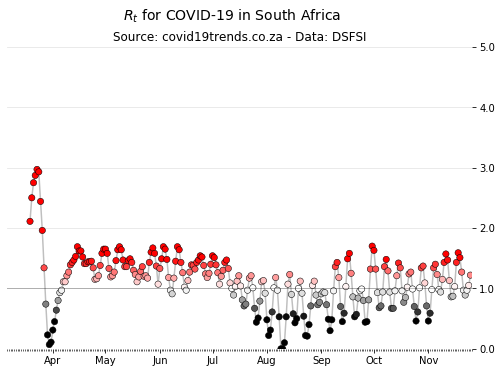

In [324]:
country = states_all_rt_i.filter(like='Total RSA', axis=0)
fig_country, ax = plt.subplots(figsize=(600/72,400/72))
ax = plot_rt(country, ax, state_name = '')
ax.set_title(credit, size=12, weight='light')
fig_country.suptitle(f'$R_t$ for COVID-19 in South Africa', size=14)

In [325]:
states_rt_i = states_all_rt_i.loc[state_filter]

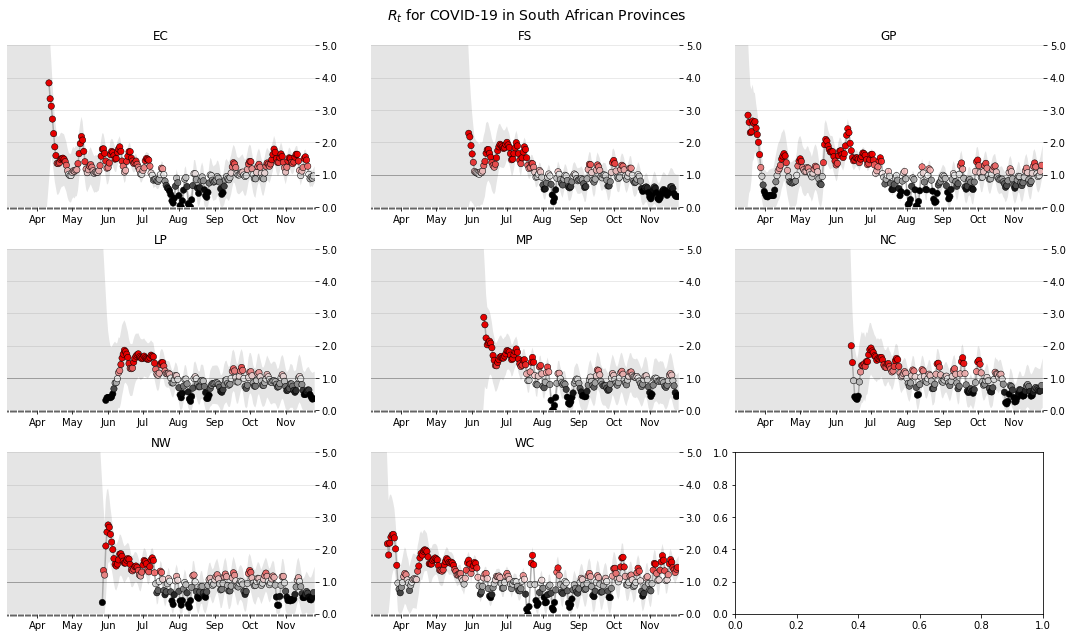

In [326]:
def all_plot(final_results):
    state_groups = final_results.groupby('state')
    
    ncols = 3
    nrows = int(np.ceil(len(state_groups) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

    for i, (state_name, result) in enumerate(state_groups):
        axes.flat[i] = plot_rt(result, axes.flat[i], state_name)

    fig.tight_layout()
    fig.set_facecolor('w')
    
    fig.suptitle(f'$R_t$ for COVID-19 in South African Provinces', size=14)
    fig.subplots_adjust(top=0.92)
    
all_plot(states_rt_i)

## Standings plots

In [327]:
# ZA: South Arica lockdown level data as of 2020/05/03
no_lockdown = [

]
partial_lockdown = [

]
# add items as required -> 'Western Cape','WC',

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [328]:
# ZA: df slighty different to US
mr = states_all_rt_i.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr

ML  High_90  Low_90
state                           
EC         0.96     1.19    0.68
FS         0.32     1.00    0.00
GP         1.29     1.72    0.80
LP         0.36     1.18    0.00
MP         0.46     1.13    0.00
NC         0.77     1.45    0.04
NW         0.66     1.34    0.02
Total RSA  1.22     0.00    0.00
WC         1.44     1.73    1.11

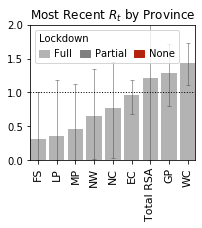

In [329]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Province'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

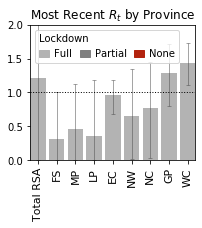

In [330]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

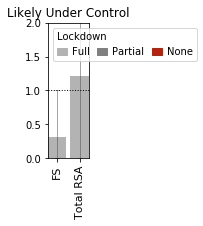

In [331]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

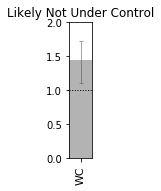

In [332]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()